# **Unsupervised Domain Adaptation**

Now we will see a particular case of Domain Adaptation, in which we do not have the labels in the new dataset.

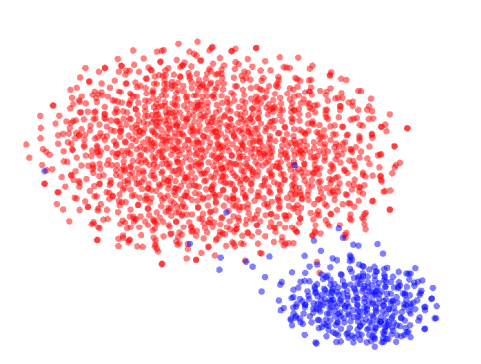

In Theory, you could just train your model on the *source-domain* and use the learned weights on the *target-domain*; they share the same classes, by assumption, so it would be feasible. Doing so, though, the performances would be low. This is because the so-called **domain-shift** problem.

Let's pretend to plot our data through t-SNE. The **red** cloud represents our *source-domain*, while the **blue** cloud represents our *target-domain*. As you can see, they belongs to different distributions. In other words, the two distributions live in different regions of the space. This mean that what is learned on the *source-domain* is useless to make classification on the *target-domain*.

Let's see this concept on the same image as above:

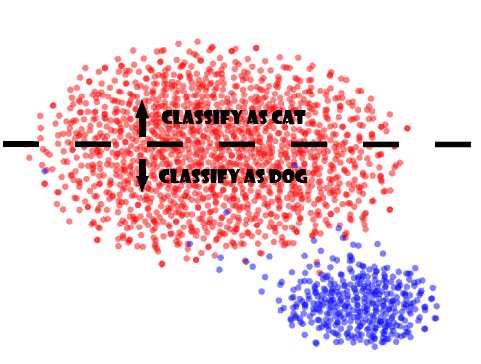

It means that all the images on the *target-domain* are going to be classified as dog.
Of course, the domain-shift during domain adaptation depends on the nature of the data we have in *source-domain* and *target-domain* (e.g., syntethic data of streets vs. real images of streets is going to have a strong domain-shift).

# **Batch Normalization for Domain Adaptation**

Through Batch Normalization we could standardize the distributions of the two domains, leveling them to the same normal distribution. In this way, the two distributions are going to live in the same region of the space, allowing our classifier to perform better.

$$
\begin{array}{l}
  \begin{matrix}
    (x, Y)\:\:
  \end{matrix}
  \text{source-domain}
  \rightarrow
  \begin{bmatrix}
    \phantom{ }\\
    \text{Conv} & \text{BN}\\
    \phantom{ }
  \end{bmatrix}
  \rightarrow
  \begin{bmatrix}
    \phantom{ }\\
    \text{Conv} & \text{BN}\\
    \phantom{ }
  \end{bmatrix}
  \rightarrow
  \begin{bmatrix}
    \phantom{ }\\
    \text{FC}\\
    \phantom{ }
  \end{bmatrix}
  \rightarrow\text{Supervised classification}
  \\
  \phantom{spacespacespacespacespaces}\updownarrow\text{ Shared weights}\updownarrow\phantom{spacespacespac}\updownarrow\\
  \begin{matrix}
    (x,\phantom{Y})\:\:
    \text{target-domain}\:
    \rightarrow
  \end{matrix}
  \begin{bmatrix}
    \phantom{ }\\
    \text{Conv} & \text{BN}\\
    \phantom{ }
  \end{bmatrix}
  \rightarrow
  \begin{bmatrix}
    \phantom{ }\\
    \text{Conv} & \text{BN}\\
    \phantom{ }
  \end{bmatrix}
  \rightarrow
  \begin{bmatrix}
    \phantom{ }\\
    \text{FC}\\
    \phantom{ }
  \end{bmatrix}
  \rightarrow\text{Regularization loss (entropy loss)}
\end{array}
$$

Notice that Batch Normalization applied on the *source-domain* and on *target-domain* is different (i.e., computed mean $\mu$ and variance $\sigma$ are different), but they share the same scale and shift parameters.

# **Let's see Domain Adaptation in action**

We are going to use `SVHN` as *source-domain* and `MNIST` as *target-domain* in two different scenarios:

- Transfer-learning (without domain adaptation):
 - Train a classifier on source `SVHN`
 - Test the classifier on target `MNIST`
 - It will provide ~ 60% test accuracy

- Transfer-learning (with domain adaptation):
 - Train a classifier on source `SVHN` and unlabeled target `MNIST`



In [1]:
import torch, torchvision
import torchvision.transforms as T
import torch.nn.functional as F
import os
from torch import nn

from torchsummary import summary

# **Define the network with Domain Alignment Layers**

Each DA layer consist of domain specific Batch Normalization Layers, followed by domain agnostic scale-shift operation. Note that the domain specific BN layer will accumulate the domain specific first and second order statistics (i.e., mean and std). It can be achieved by setting `track_running_stats=True`.

The architecture we are going to implement is as follows:

$
\begin{bmatrix}
  \phantom{ }\\
  \text{Conv}(3, 64, 5, 2) & \text{DA} & \text{ReLU}\\
  \phantom{ }
\end{bmatrix}
\rightarrow
\text{MaxPool(3, 2)}
\rightarrow
\begin{bmatrix}
  \phantom{ }\\
  \text{Conv}(64, 64, 5, 2) & \text{DA} & \text{ReLU}\\
  \phantom{ }
\end{bmatrix}
\rightarrow
\text{MaxPool}(3, 2)
\rightarrow
\begin{bmatrix}
  \phantom{ }\\
  \text{Conv}(64, 128, 5, 2) & \text{DA} & \text{ReLU}\\
  \phantom{ }
\end{bmatrix}
\rightarrow
\begin{bmatrix}
  \phantom{ }\\
  \text{Linear}(6272, 3072) & \text{DA} & \text{ReLU} & \text{Dropout}\\
  \phantom{ }
\end{bmatrix}
\rightarrow
\begin{bmatrix}
  \phantom{ }\\
  \text{Linear}(3072, 2048) & \text{DA} & \text{ReLU} & \text{Dropout}\\
  \phantom{ }
\end{bmatrix}
\rightarrow
\begin{bmatrix}\\
  \phantom{ }\
  \text{Linear}(2048, 10) & \text{DA}\\
  \phantom{ }
\end{bmatrix}
$

In [2]:
class DIALNet(torch.nn.Module):
  def __init__(self):
    super(DIALNet, self).__init__()

    self.conv1 = nn.Conv2d(3, 64, kernel_size=5, padding=2)
    # BatchNorm for source, affine=False because we want to apply the same to both
    # source and target
    self.bns1 = nn.BatchNorm2d(64, affine=False)
    # BatchNorm for target
    self.bnt1 = nn.BatchNorm2d(64, affine=False)
    self.gamma1 = nn.Parameter(torch.ones(64, 1, 1))
    self.beta1 = nn.Parameter(torch.zeros(64, 1, 1))

    self.conv2 = nn.Conv2d(64, 64, kernel_size=5, padding=2)
    self.bns2 = nn.BatchNorm2d(64, affine=False)
    self.bnt2 = nn.BatchNorm2d(64, affine=False)
    self.gamma2 = nn.Parameter(torch.ones(64, 1, 1))
    self.beta2 = nn.Parameter(torch.zeros(64, 1, 1))

    self.conv3 = nn.Conv2d(64, 128, kernel_size=5, padding=2)
    self.bns3 = nn.BatchNorm2d(128, affine=False)
    self.bnt3 = nn.BatchNorm2d(128, affine=False)
    self.gamma3 = nn.Parameter(torch.ones(128, 1, 1))
    self.beta3 = nn.Parameter(torch.zeros(128, 1, 1))

    self.fc4 = nn.Linear(6272, 3072)
    self.bns4 = nn.BatchNorm1d(3072, affine=False)
    self.bnt4 = nn.BatchNorm1d(3072, affine=False)
    self.gamma4 = nn.Parameter(torch.ones(1, 3072))
    self.beta4 = nn.Parameter(torch.ones(1, 3072))

    self.fc5 = nn.Linear(3072, 2048)
    self.bns5 = nn.BatchNorm1d(2048, affine=False)
    self.bnt5 = nn.BatchNorm1d(2048, affine=False)
    self.gamma5 = nn.Parameter(torch.ones(1, 2048))
    self.beta5 = nn.Parameter(torch.zeros(1, 2048))

    self.fc6 = nn.Linear(2048, 10)
    self.bns6 = nn.BatchNorm1d(10, affine=False)
    self.bnt6 = nn.BatchNorm1d(10, affine=False)
    self.gamma6 = nn.Parameter(torch.ones(1, 10))
    self.beta6 = nn.Parameter(torch.zeros(1, 10))


  def forward(self, x):
    # since we did not implement a specialized class for DA, this part is a bit
    # complicated

    # If we are training, we assume to have a batch which is divided in two parts:
    # the first half for the source, the second one for the target.
    if self.training:
      # apply convolution to the whole batch
      x = self.conv1(x)
      # split the batch in source and target
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0]//2, dim=0)
      # apply bns1 to source and bnt1 to target, at this point they'll share the same mean=0 and std=1.
      # Concatenate them back. Afer that, gamma and beta parameters, at this point equal for both the domains,
      # are used to de-normalize the distribution. Apply ReLU and MaxPool2d
      concat = torch.cat((self.bns1(x_source), self.bnt1(x_target)), dim=0) * self.gamma1 + self.beta1
      x = F.relu(concat)
      x = F.max_pool2d(x, kernel_size=3, stride=2)

      x = self.conv2(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0]//2, dim=0)
      concat = torch.cat((self.bns2(x_source), self.bnt2(x_target)), dim=0) * self.gamma2 + self.beta2
      x = F.relu(concat)
      x = F.max_pool2d(x, kernel_size=3, stride=2)

      x = self.conv3(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0]//2, dim=0)
      concat = torch.cat((self.bns3(x_source), self.bnt3(x_target)), dim=0) * self.gamma3 + self.beta3
      x = F.relu(concat)

      x = x.view(x.shape[0], -1)
      x = self.fc4(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0]//2, dim=0)
      concat = torch.cat((self.bns4(x_source), self.bnt4(x_target)), dim=0) * self.gamma4 + self.beta4
      x = F.relu(concat)
      x = F.dropout(x, training=self.training)

      x = self.fc5(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0]//2, dim=0)
      concat = torch.cat((self.bns5(x_source), self.bnt5(x_target)), dim=0) * self.gamma5 + self.beta5
      x = F.relu(concat)
      x = F.dropout(x, training=self.training)
      
      x = self.fc6(x)
      x_source, x_target = torch.split(x, split_size_or_sections=x.shape[0]//2, dim=0)
      x = torch.cat((self.bns6(x_source), self.bnt6(x_target)), dim=0)


    # If in Evaluation, the images are just from the target domain.
    # The steps are the same as before, but without splitting in halves
    # (since we just have the target domain) and apply just the batch
    # normalization for the target. Gamma and Beta are still used to de-normalize
    # the features.
    else:
      x = self.conv1(x)
      x = self.bnt1(x) * self.gamma1 + self.beta1
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=3, stride=2)

      x = self.conv2(x)
      x = self.bnt2(x) * self.gamma2 + self.beta2
      x = F.relu(x)
      x = F.max_pool2d(x, kernel_size=3, stride=2)

      x = self.conv3(x)
      x = F.relu(self.bnt3(x) * self.gamma3 + self.beta3)

      x = x.view(x.shape[0], -1)
      x = self.fc4(x)
      x = self.bnt4(x) * self.gamma4 + self.beta4
      x = F.relu(x)
      x = F.dropout(x, training=self.training)

      x = self.fc5(x)
      x = self.bnt5(x) * self.gamma5 + self.beta5
      x = F.relu(x)
      x = F.dropout(x, training=self.training)

      x = self.fc6(x)
      x = self.bnt6(x) * self.gamma6 + self.beta6

    return x

# **Define the losses**

For the labeled source data we can compute the *Cross-entropy* loss:

$$L^s(\theta) = -\frac{1}{m}\sum_{i=1}^m y_i\cdot \text{log}(p_i)$$

where $p_i$ is the output from the network for the $i^{\text{th}}$ input and $y_i$ is the corresponding ground truth.

In [3]:
def source_loss():
  cost_function = torch.nn.CrossEntropyLoss()
  return cost_function

for the unlabeled target samples we can no longer compute the cross entropy loss, because the labels are not available. Instead we will compute the *Entropy* loss which is defined as:

$$L^t(\theta) = -\frac{1}{m}\sum_{i=1}^m p_i \cdot \text{log}(p_i)$$

where $p_i$ is the output from the network for the $i^{\text{th}}$ input.

In [4]:
def target_loss(x):
  # Compute p_i
  p = F.softmax(x, dim=1)
  # Compute log p_i
  q = F.log_softmax(x, dim=1)

  b = p * q
  b = -1.0 * b.sum(-1).mean()
  return b

In [5]:
def train_one_epoch(model, source_loader, target_loader, optimizer, source_loss, entropy_loss_weights, device):
  source_samples = 0.
  target_samples = 0.

  cumulative_source_loss = 0.
  cumulative_target_loss = 0.
  cumulative_accuracy = 0.


  target_iter = iter(target_loader)

  model.train()

  for (x_source, y) in source_loader:
    # Gets target data. If the target iterator reaches the end, restarts it
    try:
      # if end of data is reached
      x_target, _ = next(target_iter)
    except:
      # restart data loader
      target_iter = iter(target_loader)
      # iterate again
      x_target, _ = next(target_iter)
    
    x = torch.cat((x_source, x_target), dim=0)

    # Load into GPU
    x = x.to(device)
    y = y.to(device)

    # Forward pass
    out = model(x)

    # Split source and target outputs

    source_y, target_y = torch.split(out,
                                     split_size_or_sections=out.shape[0] // 2,
                                     dim=0)

    # Apply losses
    sl = source_loss(source_y, y)
    tl = target_loss(target_y)

    loss = sl + entropy_loss_weights * tl

    # Backward pass
    loss.backward()

    # Update parameters
    optimizer.step()
    
    # Zeros the gradients
    optimizer.zero_grad()


    source_samples += x_source.shape[0]
    target_samples += x_target.shape[0]

    cumulative_source_loss += sl.item()
    cumulative_target_loss += tl.item()

    _, predicted = source_y.max(1)
    cumulative_accuracy += predicted.eq(y).sum().item()

  return cumulative_source_loss/source_samples, cumulative_target_loss/target_samples, cumulative_accuracy/source_samples*100

In [6]:
def test_one_epoch(model, loader, cost_function, device):
  samples = 0.
  cumulative_loss = 0.
  cumulative_accuracy = 0.

  model.eval()
  with torch.no_grad():
    for (x, y) in loader:
      x = x.to(device)
      y = y.to(device)

      out = model(x)

      loss = cost_function(out, y)

      samples += x.shape[0]
      cumulative_loss += loss.item()
      _, predicted = out.max(dim=1)
      cumulative_accuracy += predicted.eq(y).sum().item()
  
  return cumulative_loss/samples, cumulative_accuracy/samples*100

# **Define the DataLoader**

In [7]:
def get_data(batch_size, test_batch_size=256):

  transform_mnist = T.Compose([T.ToTensor(),
                               T.Lambda(lambda x: F.pad(x, (2, 2, 2, 2), 'constant')),
                               T.Lambda(lambda x: x.repeat(3, 1, 1)),
                               T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
  
  transform_svhn = T.Compose([T.ToTensor(),
                              T.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])
  
  source_training_data = torchvision.datasets.SVHN('./data/svhn', split='train', transform=transform_svhn, download=True)

  target_training_data = torchvision.datasets.MNIST('./data/mnist', train=True, transform=transform_mnist, download=True)
  target_test_data = torchvision.datasets.MNIST('./data/mnist', train=False, transform=transform_mnist, download=True)
  
  # Init DataLoaders
  source_train_loader = torch.utils.data.DataLoader(source_training_data, batch_size, shuffle=True, drop_last=True)
  target_train_loader = torch.utils.data.DataLoader(target_training_data, batch_size, shuffle=True, drop_last=True)

  target_test_loader = torch.utils.data.DataLoader(target_test_data, test_batch_size, shuffle=False)

  return source_train_loader, target_train_loader, target_test_loader

In [8]:
def run_model(batch_size=32, device='cuda:0', learning_rate=1e-2, weight_decay=1e-6, epochs=25, entropy_loss_weight=0.1):

  source_train_loader, target_train_loader, target_test_loader = get_data(batch_size=64)

  model = DIALNet().to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

  cost_function = source_loss()

  torch.manual_seed(42)

  for e in range(1, epochs+1):
    train_source_loss, train_target_loss, train_accuracy = train_one_epoch(model=model,
                                                                           source_loader=source_train_loader,
                                                                           target_loader=target_train_loader,
                                                                           optimizer=optimizer,
                                                                           source_loss=cost_function,
                                                                           entropy_loss_weights=entropy_loss_weight,
                                                                           device=device)
    test_loss, test_accuracy = test_one_epoch(model=model,
                                              loader=target_test_loader,
                                              cost_function=cost_function,
                                              device=device)

    print('Epoch: {:d}'.format(e))
    print('\t Train: Source loss {:.5f}, Target loss {:.2f}, Accuracy {:.2f}'.format(train_source_loss, train_target_loss, train_accuracy))
    print('\t Test: Source loss {:.5f}, Accuracy {:.2f}'.format(test_loss, test_accuracy))
    print('-----------------------------------------------------')

In [9]:
run_model()

  0%|          | 0/182040794 [00:00<?, ?it/s]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/mnist/MNIST/raw

Epoch: 1
	 Train: Source loss 0.01556, Target loss 0.02, Accuracy 73.84
	 Test: Source loss 0.00236, Accuracy 88.70
-----------------------------------------------------
Epoch: 2
	 Train: Source loss 0.01028, Target loss 0.02, Accuracy 88.35
	 Test: Source loss 0.00211, Accuracy 91.57
-----------------------------------------------------
Epoch: 3
	 Train: Source loss 0.00960, Target loss 0.02, Accuracy 90.07
	 Test: Source loss 0.00188, Accuracy 93.52
-----------------------------------------------------
Epoch: 4
	 Train: Source loss 0.00927, Target loss 0.02, Accuracy 91.03
	 Test: Source loss 0.00164, Accuracy 95.64
-----------------------------------------------------
Epoch: 5
	 Train: Source loss 0.00902, Target loss 0.02, Accuracy 91.61
	 Test: Source loss 0.00167, Accuracy 95.48
-----------------------------------------------------
Epoch: 6
	 Train: Source loss 0.00884, Target loss 0.02, Accura

With respect to fine-tuning (just by transfering the weights), here we gain around ~20% accuracy